 <hr style="height:.9px;border:none;color:#333;background-color:#333;" />
<hr style="height:.9px;border:none;color:#333;background-color:#333;" />

<b>Apprentice Chef | Analysis Report to Management</b>
<br>
<b>DAT-5303 | Machine Learning<b>
<br>
Joshua Dienye
<br>
Hult International Business School<br>

<hr style="height:.9px;border:none;color:#333;background-color:#333;" />
<hr style="height:.9px;border:none;color:#333;background-color:#333;" />

In [1]:
# importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf                
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score            
from sklearn.neighbors import KNeighborsClassifier   
from sklearn.neighbors import KNeighborsRegressor    
from sklearn.preprocessing import StandardScaler     
from sklearn.tree import DecisionTreeClassifier      
from sklearn.tree import export_graphviz            
from six import StringIO          
from IPython.display import Image                    
import pydotplus                                    
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import make_scorer              
from sklearn.ensemble import RandomForestClassifier    
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
# storing file path as file
file = './Apprentice_Chef_Dataset.xlsx'

# creating dataset using the file path
ac_dataset = pd.read_excel(io = file)

# setting pandas print options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# changing all column names to lowercase
ac_dataset.columns = ac_dataset.columns.str.lower()

In [4]:
# UDF to count number of names of each customer
def text_split_feature(col, df, sep = ' ', new_col_name = 'NUM_OF_NAMES'):
    """
Splits values in a string Series (as part of a DataFrame) and sums the number
of resulting items. Automatically appends summed column to original DataFrame.

PARAMETERS
----------
col          : column to split
df           : DataFrame where column is located
sep          : string sequence to split by, default ' '
new_col_name : name of new column after summing split, default
               'number_of_names'
"""
    # creating new column
    df[new_col_name] = 0
    
    # for loop to split names and count total
    for index, val in df.iterrows():
        df.loc[index, new_col_name] = len(df.loc[index, col].split(sep = ' '))
        
# creating new column for number of names each customer has
text_split_feature(col = 'name', df = ac_dataset, 
                   new_col_name = 'number_of_names')

# dropping columns name, first_name, and family_name
ac_dataset = ac_dataset.drop(['name', 'first_name', 'family_name'], axis = 1)

In [5]:
# log transformation of revenue and saving as new column
ac_dataset['log_revenue'] = np.log10(ac_dataset['revenue'])

# creating new columns for thresholds
ac_dataset['log_revenue_one'] = 0
ac_dataset['log_revenue_two'] = 0
ac_dataset['log_revenue_three'] = 0

# for loop to mark customers who meet the thresholds
for index, value in ac_dataset.iterrows():
    if ac_dataset.loc[index, 'log_revenue'] >= 3.40:
        ac_dataset.loc[index, 'log_revenue_three'] = 1
    elif ac_dataset.loc[index, 'log_revenue'] >= 3.15:
        ac_dataset.loc[index, 'log_revenue_two'] = 1
    elif ac_dataset.loc[index, 'log_revenue'] >= 2.85:
        ac_dataset.loc[index, 'log_revenue_one'] = 1
    else:
        continue

In [6]:
# log transformation of avg_prep_vid_time and saving as new column
ac_dataset['log_avg_prep_vid_time'] = np.log10(ac_dataset['avg_prep_vid_time'])

# creating new columns for thresholds
ac_dataset['vid_prep_one'] = 0
ac_dataset['vid_prep_two'] = 0

# for loop to mark customers who meet the thresholds
for index, value in ac_dataset.iterrows():
    if ac_dataset.loc[index, 'log_avg_prep_vid_time'] >= 2.60:
        ac_dataset.loc[index, 'vid_prep_one'] = 1
    elif ac_dataset.loc[index, 'log_avg_prep_vid_time'] >= 1.75:
        ac_dataset.loc[index, 'vid_prep_two'] = 1
    else:
        continue

In [7]:
# log transformation of avg_time_per_site_visit and saving as new column
ac_dataset['log_avg_time_per_site_visit'] = np.log10(ac_dataset['avg_time_per_site_visit'])

# creating new columns for thresholds
ac_dataset['visit_time_one'] = 0
ac_dataset['visit_time_two'] = 0
ac_dataset['visit_time_three'] = 0

# for loop to mark customers who meet the thresholds
for index, value in ac_dataset.iterrows():
    if ac_dataset.loc[index, 'log_avg_prep_vid_time'] >= 2.50:
        ac_dataset.loc[index, 'visit_time_three'] = 1
    elif ac_dataset.loc[index, 'log_avg_prep_vid_time'] >= 2.00:
        ac_dataset.loc[index, 'visit_time_two'] = 1
    elif ac_dataset.loc[index, 'log_avg_prep_vid_time'] >= 1.75:
        ac_dataset.loc[index, 'visit_time_one'] = 1
    else:
        continue

In [8]:
# engineering feature for total time spent on website
ac_dataset['total_avg_time_on_site'] = ac_dataset['avg_prep_vid_time'] +\
                                   ac_dataset['avg_time_per_site_visit']

# log transformation of total_avg_time_on_site and saving as new column
ac_dataset['log_total_avg_time_on_site'] = np.log10(ac_dataset['total_avg_time_on_site'])

# creating new column for thresholds
ac_dataset['time_on_site_one'] = 0

# for loop to mark customers who meet the threshold
for index, value in ac_dataset.iterrows():
    if ac_dataset.loc[index, 'log_avg_prep_vid_time'] >= 2.50:
        ac_dataset.loc[index, 'time_on_site_one'] = 1

In [9]:
# creating lists for different categories
prof_email = ['mmm', 'amex', 'apple', 'boeing', 'caterpillar', 'chevron',
             'cisco', 'cocacola', 'disney', 'dupont', 'exxon', 'ge', 'walmart',
             'goldmansacs', 'homedepot', 'ibm', 'intel', 'jnj', 'jpmorgan',
             'mcdonalds', 'merck', 'microsoft', 'nike', 'pfizer', 'pg',
             'travelers', 'unitedtech', 'unitedhealth', 'verizon', 'visa']
per_email = ['gmail', 'yahoo', 'protonmail']
junk_email = ['me', 'aol', 'hotmail', 'live', 'msn', 'passport']

# creating a column email_category with just zeros
ac_dataset['email_category'] = '0'

# for loop to check the domain name and classify it based on grouping from
# marketing team
for index, email in ac_dataset[['email']].iterrows():
    domain_name = re.findall('@+\S+[.com|.org]', email[0])[0]
    for pattern in ['@', '.com', '.org']:
        domain_name = domain_name.replace(pattern, '')
    if domain_name in prof_email:
        ac_dataset.loc[index, 'email_category'] = 'Professional'
    elif domain_name in per_email:
        ac_dataset.loc[index, 'email_category'] = 'Personal'
    elif domain_name in junk_email:
        ac_dataset.loc[index, 'email_category'] = 'Junk'
    else:
        ac_dataset.loc[index, 'email_category'] = 'Undefined'
        
# one hot encoding email_category
one_hot_email = pd.get_dummies(ac_dataset['email_category'], 
                               prefix = 'email')

# joining codings together
ac_dataset = ac_dataset.join(one_hot_email)

# changing all column names to lowercase
ac_dataset.columns = ac_dataset.columns.str.lower()

In [10]:
# creating new column to hold domain names
ac_dataset['domain_name'] = 0

# for loop to strip emails to get only domain names
for index, email in ac_dataset[['email']].iterrows():
    domain_name = re.findall('@+\S+[.com|.org]', email[0])[0]
    for pattern in ['@', '.com', '.org']:
        domain_name = domain_name.replace(pattern, '')
    ac_dataset.loc[index, 'domain_name'] = domain_name
    
# a list of all email domains highly correlated with cross_sell_success
email_list_one = ['aol', 'hotmail', 'msn', 'live']
email_list_two = ['microsoft', 'merck', 'jpmorgan', 'pg', 'amex', 'intel', 
                  'passport', 'me', 'caterpillar', 'unitedhealth']

# creating new column for different email categories
ac_dataset['email_categories'] = 0

# for loop to group mail into different categories
for index, domain in ac_dataset[['domain_name']].iterrows():
    if domain[0] in email_list_one:
        ac_dataset.loc[index, 'email_categories'] = 'group_one'
    elif domain[0] in email_list_two:
        ac_dataset.loc[index, 'email_categories'] = 'group_two'
    else:
        ac_dataset.loc[index, 'email_categories'] = 'group_three'
        
# one hot encoding email_category
one_hot_email_groups = pd.get_dummies(ac_dataset['email_categories'], 
                               prefix = 'email')

# joining codings together
ac_dataset = ac_dataset.join(one_hot_email_groups)

# dropping columns not used
ac_dataset = ac_dataset.drop(['email_category', 'email_personal', 'email',
                              'email_categories', 'email_group_three', 
                              'domain_name'], axis = 1)

In [11]:
# changing the column name
ac_dataset = ac_dataset.rename(columns = {'largest_order_size': 'avg_order_size'})

In [12]:
# creating new feature for total logins 
ac_dataset['total_logins'] = ac_dataset['pc_logins'] + ac_dataset['mobile_logins']

In [13]:
# if early_delivries and late_deliveries both equal to zero, then customer
# got deliveries on-time every time 

# creating empty column
ac_dataset['delivery_time'] = 0

# for loop to create column with delivery description
for index, value in ac_dataset.iterrows():
        #if early and late equals to zero
        if ac_dataset.loc[index, 'early_deliveries'] == 0\
        and ac_dataset.loc[index, 'late_deliveries'] == 0:
            ac_dataset.loc[index, 'delivery_time'] = 'on_time'
        #if early and late greater than zero
        elif ac_dataset.loc[index, 'early_deliveries'] > 0\
        and ac_dataset.loc[index, 'late_deliveries'] > 0: 
            ac_dataset.loc[index, 'delivery_time'] = 'mixed'
        #if early greater than zero
        elif ac_dataset.loc[index, 'early_deliveries'] > 0: 
            ac_dataset.loc[index, 'delivery_time'] = 'early' 
        #if late greater than zero
        elif ac_dataset.loc[index, 'late_deliveries'] > 0: 
            ac_dataset.loc[index, 'delivery_time'] = 'late'
        # for handling errors
        else:
            ac_dataset.loc[index, 'delivery_time'] = 'unknown' 
            
# one hot encoding delivery_time
one_hot_email = pd.get_dummies(ac_dataset['delivery_time'], 
                               prefix = 'delivery_time')

# joining codings togetherz
ac_dataset = ac_dataset.join(one_hot_email)

# changing all column names to lowercase
ac_dataset.columns = ac_dataset.columns.str.lower()

# dropping categorical variables after encoding
ac_dataset = ac_dataset.drop(['delivery_time', 'delivery_time_on_time'],
                             axis = 1)

In [14]:
# if cancellations_before_noon and cancellations_after_noon both equal 
# to zero, then customer never cancelled 

# creating empty column
ac_dataset['cancellations'] = 0

# for loop to create column with cancellation description
for index, value in ac_dataset.iterrows():
        #if before_noon and after_noon equals to zero
        if ac_dataset.loc[index, 'cancellations_before_noon'] == 0\
        and ac_dataset.loc[index, 'cancellations_after_noon'] == 0:
            ac_dataset.loc[index, 'cancellations'] = 'none'
        #if before_noon greater than zero
        elif ac_dataset.loc[index, 'cancellations_before_noon'] > 0: 
            ac_dataset.loc[index, 'cancellations'] = 'before_noon' 
        #if after_noon greater than zero
        elif ac_dataset.loc[index, 'cancellations_after_noon'] > 0: 
            ac_dataset.loc[index, 'cancellations'] = 'after_noon'
        # for handling errors
        else:
            ac_dataset.loc[index, 'cancellations'] = 'unknown' 
            
# one hot encoding cancellations
one_hot_email = pd.get_dummies(ac_dataset['cancellations'], 
                               prefix = 'any_cancellations')

# joining codings together
ac_dataset = ac_dataset.join(one_hot_email)

# changing all column names to lowercase
ac_dataset.columns = ac_dataset.columns.str.lower()

# dropping categorical variables after encoding
ac_dataset = ac_dataset.drop(['cancellations', 'any_cancellations_none'],
                             axis = 1)

In [15]:
# engineering new variables
ac_dataset['revenue_per_meal'] = ac_dataset['revenue'] / \
                                 ac_dataset['total_meals_ordered']
ac_dataset['unique_meal_ratio'] = ac_dataset['unique_meals_purch'] / \
                                 ac_dataset['total_meals_ordered']

# log transformation of revenue_per_meal and saving as new column
ac_dataset['log_revenue_per_meal'] = np.log10(ac_dataset['revenue_per_meal'])

# log transformation of revenue_per_meal and saving as new column
ac_dataset['log_unique_meal_ratio'] = np.log10(ac_dataset['unique_meal_ratio'])

In [16]:
# creating variable for count varibale columns
count_variables = ['avg_clicks_per_visit', 'median_meal_rating', 
                   'avg_order_size', 'pc_logins', 'unique_meals_purch', 
                   'contacts_w_customer_service', 'product_categories_viewed']

# creating variable for count varibale columns with zeros
count_variables_zero = ['total_photos_viewed', 'master_classes_attended',
                        'mobile_logins', 'weekly_plan', 'early_deliveries',
                        'late_deliveries', 'cancellations_before_noon',
                        'cancellations_after_noon']

In [17]:
# dummy variable for each variable in count_variables_zero

# for each variable in count_variables_zero
for variable in count_variables_zero:
    # create column filled with zero
    ac_dataset['has_' + variable] = 0
    # creating index and value variables for each row
    for index, value in ac_dataset.iterrows():
        # if value in variable column greater than zero
        if ac_dataset.loc[index, (variable)] > 0:
            # turn the value in that index to one
            ac_dataset.loc[index, ('has_' + variable)] = 1

In [18]:
# performing a log transform on all count variables 
for variable in count_variables:
    ac_dataset['log_' + variable] = np.log10(ac_dataset[variable])
    
# performing log transformation on total_meals_ordered
ac_dataset['log_total_meals_ordered'] = np.log10(ac_dataset['total_meals_ordered'])

In [19]:
# creating empty columns for engineered variables 
ac_dataset['procastinator'] = 0
ac_dataset['working'] = 0 
ac_dataset['active_pc_user'] = 0 
ac_dataset['common_user'] = 0 
ac_dataset['weekend_fighter'] = 0 

# for loop to create features
for index, value in ac_dataset.iterrows():
    if ac_dataset.loc[index, 'email_junk'] == 1 and \
    ac_dataset.loc[index, 'avg_time_per_site_visit'] >= 99.6:
        ac_dataset.loc[index, 'procastinator'] = 1  
    if ac_dataset.loc[index, 'email_professional'] == 1 and \
    ac_dataset.loc[index, 'avg_time_per_site_visit'] <= 99.6:
        ac_dataset.loc[index, 'working'] = 1    
    if ac_dataset.loc[index, 'pc_logins'] > 5 and \
    ac_dataset.loc[index, 'avg_time_per_site_visit'] >= 99.6 and \
    ac_dataset.loc[index, 'mobile_logins']:
        ac_dataset.loc[index, 'active_pc_user'] = 1  
    if ac_dataset.loc[index, 'revenue_per_meal'] >= 25:
        ac_dataset.loc[index, 'common_user'] = 1      
    if ac_dataset.loc[index, 'total_meals_ordered'] <= 60 and \
    ac_dataset.loc[index, 'revenue_per_meal'] > 34:
        ac_dataset.loc[index, 'weekend_fighter'] =1

# INTRODUCTION

Apprentice Chef, Inc. is an innovative company with a new way to serve customers' needs to prepare food. Meal sets can be ordered via the website or the mobile application and delivered directly to the customer. The goal of this analysis is to analyze the data and develop key insights into our customers. 

# REVENUE

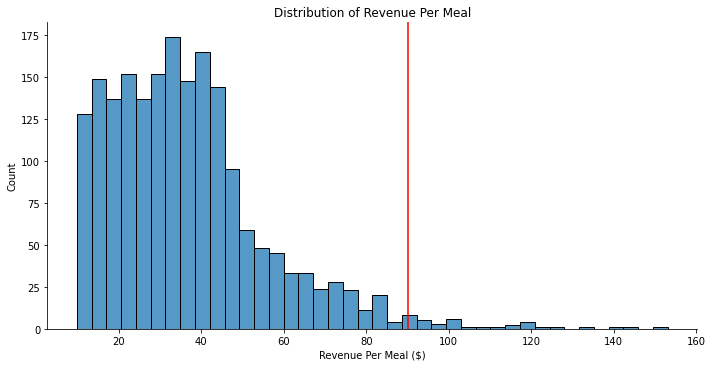

In [20]:
# displaying the plot for revenue per meal
sns.displot(x = 'revenue_per_meal',
           data = ac_dataset,
           height = 5,
           aspect = 2)

# showing vertical line for threshold
plt.axvline(x = 90, color = 'red')

# title and labels
plt.title('Distribution of Revenue Per Meal')
plt.xlabel('Revenue Per Meal ($)')

# displaying the plot
plt.show()

When looking at revenue per meal, 30 customers spend above $90 per meal. Although the number of customers is small, they contribute approximately 2% of the total revenue. An account manager should be assigned to these customers to ensure a smoother purchase experience and to ensure their purchases remain frequent. 

In [21]:
# setting condition
condition = ac_dataset['revenue_per_meal'] > 90

In [22]:
# # percentage of customers spending more than condition per meal
# print(f'''
# Number of customers above threshold: {len(ac_dataset['revenue_per_meal'][condition])}''')

# print(f'''
# Percentage of revenue contributed: {round(sum(ac_dataset['revenue'][condition])/sum(ac_dataset['revenue']), 
#             ndigits = 2)*100}
#             ''')

In [23]:
# preparing explanatory variable data
ac_data = ac_dataset.drop(['revenue', 'log_revenue'], axis = 1)

# preparing response variables
ac_target = ac_dataset.loc[ : , 'revenue']
log_ac_target = ac_dataset.loc[ : , 'log_revenue']

x_variables = ['cross_sell_success', 'total_meals_ordered', 'unique_meals_purch',
               'product_categories_viewed', 'avg_order_size', 'median_meal_rating',
               'total_photos_viewed', 'log_avg_prep_vid_time', 
               'log_unique_meals_purch',
               'log_contacts_w_customer_service', 'log_product_categories_viewed',
               'log_total_meals_ordered']

# preparing x-variables from the OLS model
ols_data = ac_dataset[x_variables]

# preparing training and testing sets for log_revenue removing high p-values
X_train_ols, X_test_ols, y_train_ols, y_test_ols = train_test_split(
                                                        ols_data,
                                                        log_ac_target,
                                                        test_size = 0.25,
                                                        random_state = 219)
# instantiating model object
lr = LinearRegression()

# fitting to training data 
lr_fit = lr.fit(X_train_ols, y_train_ols)

# predicting on new data
lr_pred = lr_fit.predict(X_test_ols)

# zipping each feature name to its coefficient
lr_model_values = zip(ac_dataset[x_variables].columns,
                     lr_fit.coef_.round(decimals = 4))

# setting up a placeholder list to store model features
lr_model_lst = [('intercept', lr_fit.intercept_.round(decimals = 4))]

# printing out each feature-coefficient pair one by one
for val in lr_model_values:
    lr_model_lst.append(val)

# # scoring the results
# print('OLS Training Score :', lr.score(X_train_ols, y_train_ols).round(6))  # using R-square
# print('OLS Testing Score  :',  lr.score(X_test_ols, y_test_ols).round(6)) # using R-square

lr_train_score = lr.score(X_train_ols, y_train_ols).round(4)
lr_test_score  = lr.score(X_test_ols, y_test_ols).round(4)

# # displaying and saving the gap between training and testing
# print('OLS Train-Test Gap :', abs(lr_train_score - lr_test_score).round(4))
# lr_test_gap = abs(lr_train_score - lr_test_score).round(4)

A regression model with an R-Square value of 76.386% was created. From this model, we determined the variables with the most positive and negative effects are log average preparation video time and log unique meals purchased, respectively.  A 1% increase in revenue is associated with a 0.59% increase in average preparation video time, while a 1% increase in revenue is associated with a 0.61% decrease in unique meals purchased. 

In [24]:
# creating a dataframe with the coefficients
coeffs = pd.DataFrame(lr_model_lst)

# creating a list of coeff names 
coef_names = ['Intercept', 'Cross Sell Sucess', 'Total Meals Ordered',
              'Unique Meals Purchased', 'Product Categories Viewed',
              'Average Order Size', 'Median Meal Rating', 
              'Total Photos Viewed', 'Log Average Prep Video Time',
              'Log Unique Meals Purchased', 'Log Contacts with Customer Service',
              'Log Product Categories Viewed', "Log Total Meals Ordered"]

# renaming the coeffs
coeffs[0] = coef_names

# renaming the dataframe column names
coeffs.columns = ['Labels', 'Coefs']

# calling the dataframe
coeffs

,Labels,Coefs
0,Intercept,1.2323
1,Cross Sell Sucess,-0.0152
2,Total Meals Ordered,-0.0008
3,Unique Meals Purchased,0.0517
4,Product Categories Viewed,0.0106
5,Average Order Size,-0.0149
6,Median Meal Rating,0.0635
7,Total Photos Viewed,0.0001
8,Log Average Prep Video Time,0.5924
9,Log Unique Meals Purchased,-0.6158


# CROSS-SELL SUCCESS

In [25]:
# creating a varibale with features for random forest
x_two_variables = ['total_meals_ordered', 'log_contacts_w_customer_service',
                   'mobile_number', 'cancellations_before_noon',
                   'tastes_and_preferences', 'mobile_logins', 'weekly_plan',
                   'log_avg_prep_vid_time', 'has_master_classes_attended',
                   'log_pc_logins', 'email_junk', 'procastinator',
                   'email_professional', 'log_product_categories_viewed',
                   'working', 'active_pc_user', 'common_user',
                   'weekend_fighter', 'number_of_names']


# train/test split with the full model
ac_data   =  ac_dataset[x_two_variables]
ac_target =  ac_dataset.loc[ : , 'cross_sell_success']

# this is the exact code we were using before
X_train, X_test, y_train, y_test = train_test_split(
            ac_data,
            ac_target,
            random_state = 219,
            test_size    = 0.25,
            stratify     = ac_target)


# instantiating model
forest_tuned = RandomForestClassifier(bootstrap=False, max_depth=8, max_features='sqrt',
                        min_samples_split=4, n_estimators=350, random_state=219)

# FITTING the model object
forest_tuned_fit = forest_tuned.fit(ac_data, ac_target)

# PREDICTING based on the testing set
forest_tuned_pred = forest_tuned_fit.predict(X_test)

# # SCORING the results
# print('Forest Tuned Training ACCURACY:', forest_tuned.score(X_train, y_train).round(4))
# print('Forest Tuned Testing  ACCURACY:', forest_tuned.score(X_test, y_test).round(4))

# saving scoring data for future use
forest_tuned_train_score = forest_tuned.score(X_train, y_train).round(4) # accuracy
forest_tuned_test_score  = forest_tuned.score(X_test, y_test).round(4)   # accuracy

# # displaying and saving the gap between training and testing
# print('Forest Train-Test Gap   :', abs(forest_tuned_train_score - \
#                                        forest_tuned_test_score).round(4))

forest_tuned_gap = abs(forest_tuned_train_score - forest_tuned_test_score).round(4)

# unpacking the confusion matrix
rand_forest_tn, \
rand_forest_fp, \
rand_forest_fn, \
rand_forest_tp = confusion_matrix(y_true = y_test, y_pred = forest_tuned_pred).ravel()


# # printing each result one-by-one
# print(f"""
# True Negatives : {rand_forest_tn}
# False Positives: {rand_forest_fp}
# False Negatives: {rand_forest_fn}
# True Positives : {rand_forest_tp}
# """)

# saving the AUC score
forest_tuned_auc = roc_auc_score(y_true  = y_test,
                                 y_score = forest_tuned_pred).round(4) # auc


# print('Forest Tuned AUC Score        :', roc_auc_score(y_true  = y_test,
#                                                         y_score = forest_tuned_pred).round(6))

In [26]:
# UDF for plotting feature importance
def plot_feature_importances(model, train, export = False):
    """
    Plots the importance of features from a CART model.
    
    PARAMETERS
    ----------
    model  : CART model
    train  : explanatory variable training data
    export : whether or not to export as a .png image, default False
    """
    
    # declaring the number
    n_features = train.shape[1]
    
    # setting plot window
    fig, ax = plt.subplots(figsize=(12,9))
    
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), train.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    
    if export == True:
        plt.savefig('./analysis_images/Feature_Importance.png')

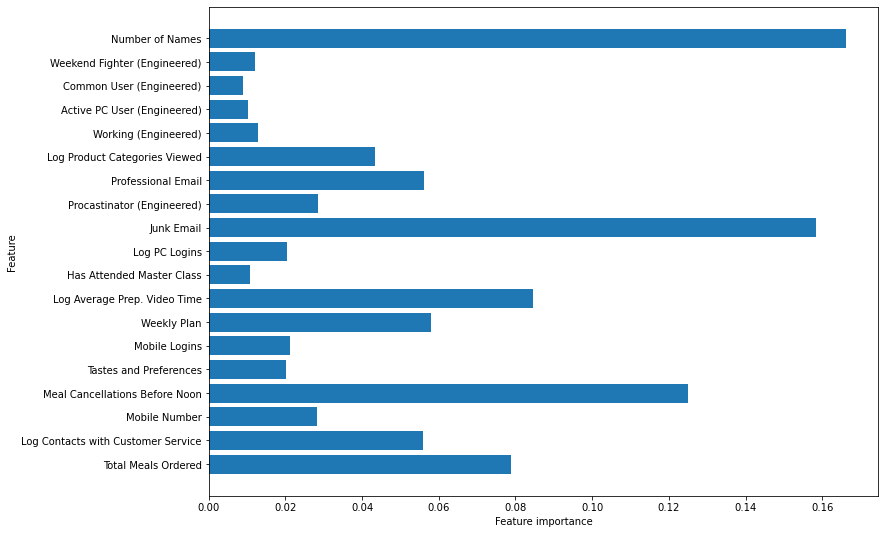

In [27]:
# creating a varibale with feature names
column_names = ['Total Meals Ordered', 'Log Contacts with Customer Service', 
                'Mobile Number', 'Meal Cancellations Before Noon', 
                'Tastes and Preferences', 'Mobile Logins', 'Weekly Plan',
                'Log Average Prep. Video Time', 'Has Attended Master Class',
                'Log PC Logins', 'Junk Email', 'Procastinator (Engineered)',
                'Professional Email', 'Log Product Categories Viewed', 
                'Working (Engineered)', 'Active PC User (Engineered)', 
                'Common User (Engineered)', 'Weekend Fighter (Engineered)', 
                'Number of Names']

# renaming colums
X_train.columns = column_names

# plotting feature importances
plot_feature_importances(forest_tuned_fit,
                         train = X_train,
                         export = False)

A random forest model with an AUC score of 80.976% was created. According to the model, one of the most important variables is Junk mail. Halfway There promotional campaigns should be targeted at users with the email providers classified as junk.

Even in this model, the importance of log average preparation video time is seen. The company should look into ways to increase the amount of time spent watching preparation videos. This increase could lead to a rise in not only revenue but also cross-sell success.

# Conclusion

These models can be used to predict customers' behaviors and also check what influences their decisions. The company should use the insights derived from these models to direct the customer-facing choices of the company. 